In [11]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit

!pip install imblearn
from imblearn.over_sampling import ADASYN

In [12]:
# Import recategorised data
wholedata = pd.read_csv("recategorised_data.csv")
wholedata.describe()

,Entero,Rain24,Rain48,Rain72,RainWA,Wdirection,Wspeed,Solarhours,BeachType,BeachDirection,Entero_level,Wspeed_level,Wdirection_level,on_offshore
count,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,182.596926,2.052960,4.378617,6.878463,13.310040,187.879028,2.702033,6.703718,0.491324,4.221616,0.073872,1.010412,8.029251,0.869113
std,1271.550681,5.678971,9.307389,12.594966,25.209095,90.915915,1.670540,3.849683,0.500049,4.995729,0.261627,0.106303,4.073803,0.861271
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.000000,0.000000,0.000000,0.000000,113.000000,1.500000,3.500000,0.000000,1.000000,0.000000,1.000000,5.000000,0.000000
50%,10.000000,0.000000,0.490000,1.460000,2.420000,211.000000,2.400000,7.200000,0.000000,2.000000,0.000000,1.000000,9.000000,1.000000
75%,20.000000,0.980000,4.290000,7.730000,15.160000,253.000000,3.400000,10.000000,1.000000,10.000000,0.000000,1.000000,11.000000,2.000000
max,24196.000000,57.900000,115.250000,127.320000,251.620000,360.000000,14.200000,14.100000,1.000000,15.000000,1.000000,2.000000,15.000000,2.000000


In [13]:
wholedata.head()

,DATE,Entero,Rain24,Rain48,Rain72,RainWA,Wdirection,Wspeed,Solarhours,BeachName,BeachType,BeachDirection,Entero_level,Wspeed_level,Wdirection_level,on_offshore
0,1995-12-16,10.0,9.17,13.67,37.00,59.84,200,1.5,1.8,Clarks,1,15,0,1,9,0
1,1995-12-27,10.0,0.00,0.00,0.33,0.33,230,5.7,8.5,Clarks,1,15,0,1,10,2
2,1995-12-28,10.0,2.50,2.50,2.50,7.50,320,3.6,11.7,Clarks,1,15,0,1,14,1
3,1996-01-07,10.0,0.00,0.00,0.00,0.00,130,4.1,7.9,Clarks,1,15,0,1,6,0
4,1996-01-08,10.0,0.00,0.00,0.00,0.00,100,3.6,4.4,Clarks,1,15,0,1,4,2


In [14]:
wholedata['DATE']=wholedata['DATE'].astype('datetime64')

In [21]:
# put aside test_set for final test
test_set = wholedata[wholedata['DATE'].dt.year>=2017]
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 215 to 2016
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATE              105 non-null    datetime64[ns]
 1   Entero            105 non-null    float64       
 2   Rain24            105 non-null    float64       
 3   Rain48            105 non-null    float64       
 4   Rain72            105 non-null    float64       
 5   RainWA            105 non-null    float64       
 6   Wdirection        105 non-null    int64         
 7   Wspeed            105 non-null    float64       
 8   Solarhours        105 non-null    float64       
 9   BeachName         105 non-null    object        
 10  BeachType         105 non-null    int64         
 11  BeachDirection    105 non-null    int64         
 12  Entero_level      105 non-null    int64         
 13  Wspeed_level      105 non-null    int64         
 14  Wdirection_level  105 n

In [22]:
# train/validation set excluding test_set
data_frame = wholedata[wholedata['DATE'].dt.year<2017]
data_frame = data_frame[data_frame['DATE'].dt.year>=2015]
data_frame = data_frame.sort_values(by=['DATE'])
data_frame = data_frame.reset_index()
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             221 non-null    int64         
 1   DATE              221 non-null    datetime64[ns]
 2   Entero            221 non-null    float64       
 3   Rain24            221 non-null    float64       
 4   Rain48            221 non-null    float64       
 5   Rain72            221 non-null    float64       
 6   RainWA            221 non-null    float64       
 7   Wdirection        221 non-null    int64         
 8   Wspeed            221 non-null    float64       
 9   Solarhours        221 non-null    float64       
 10  BeachName         221 non-null    object        
 11  BeachType         221 non-null    int64         
 12  BeachDirection    221 non-null    int64         
 13  Entero_level      221 non-null    int64         
 14  Wspeed_level      221 non-

In [23]:
### KNN with balanced data - add 'on_offshore' plus removed 'Rain48' and 'RainWA'
print("KNN (n=5) model with ADASYN (n=10) balanced data - add 'on_offshore' plus removed 'Rain48' and 'RainWA'")
data_set = data_frame.iloc[:,3:10]
data_set[['on_offshore','Entero_level']] = data_frame[['on_offshore','Entero_level']]
data_set = data_set.drop(columns=['Rain48', 'RainWA'])
print("data_set -", end =" ")
print(data_set.columns.values)

KNN (n=5) model with ADASYN (n=10) balanced data - add 'on_offshore' plus removed 'Rain48' and 'RainWA'
data_set - ['Rain24' 'Rain72' 'Wdirection' 'Wspeed' 'Solarhours' 'on_offshore'
 'Entero_level']


In [26]:
# ADASYN
ada = ADASYN(sampling_strategy=1, n_neighbors=1)

# Define normalisation scaler
sc = preprocessing.StandardScaler()

Observations: 111
Training observations: 56
Testing observations: 55
Overall accuracy:
0.8727272727272727
Confusion matrix
[[47  6]
 [ 1  1]]
Observations: 166
Training observations: 111
Testing observations: 55
Overall accuracy:
0.8363636363636363
Confusion matrix
[[44  5]
 [ 4  2]]
Observations: 221
Training observations: 166
Testing observations: 55
Overall accuracy:
0.7636363636363637
Confusion matrix
[[40  6]
 [ 7  2]]


C:\Users\HP-family desktop\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\HP-family desktop\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\HP-family desktop\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


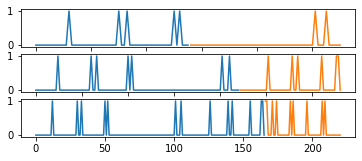

In [27]:
# Multiple train-test splits
splits=TimeSeriesSplit(n_splits=3)
plt.figure(1)
index=1
for train_index,test_index in splits.split(data_set):
    train=data_set.loc[train_index]
    test=data_set.loc[test_index]
    print('Observations: %d' % (len(train)+len(test)))
    print('Training observations: %d' % (len(train)))
    print('Testing observations: %d' % (len(test)))
    input_data = train.iloc[:,0:6]
    entero_data = train.iloc[:,6]
    testset_data = test.iloc[:,0:6]
    testset_labels = test.iloc[:,6]
    # Generate synthetic sampling data with ADASYN
    data_fake, entero_fake = ada.fit_resample(input_data, entero_data)
    trainset_data=pd.DataFrame(data_fake, columns=['Rain24','Rain72','Wdirection','Wspeed','Solarhours','on_offshore'])
    trainset_labels=pd.DataFrame(entero_fake, columns=['Entero_level'])
    # Train data normalization
    trainset_data = sc.fit_transform(trainset_data)
    testset_data = sc.transform(testset_data)
    # Run KNN with sklearn
    knn = KNeighborsClassifier(n_neighbors = 5,algorithm='auto',leaf_size=30,metric='minkowski',metric_params=None,n_jobs=1,p=2,weights='uniform')
    knn.fit(trainset_data, trainset_labels)
    # Show the KNN result
    #print("Predictions from the knn classifier:")
    #print(knn.predict(testset_data))
    #print("Target values:")
    #print(testset_labels)
    print("Overall accuracy:")
    print(accuracy_score(testset_labels,knn.predict(testset_data)))
    print("Confusion matrix")
    print(confusion_matrix(testset_labels,knn.predict(testset_data)))
    plt.subplot(510+index)
    plt.plot(entero_data)
    plt.plot([None for i in entero_data]+[x for x in testset_labels])
    #plt.subplot(510+index)
    #plt.plot([x for x in knn.predict(testset_data)])
    #plt.plot([x for x in testset_labels])
    index +=1
plt.show()    

In [28]:
# Final model test on separate test-set
data_set = test_set.iloc[:,2:9]
data_set[['on_offshore','Entero_level']] = test_set[['on_offshore','Entero_level']]
data_set = data_set.drop(columns=['Rain48', 'RainWA'])
test_set_data = data_set.iloc[:,0:6]
test_set_labels = data_set.iloc[:,6]

print("Overall accuracy:")
print(accuracy_score(test_set_labels,knn.predict(test_set_data)))
print("Confusion matrix")
print(confusion_matrix(test_set_labels,knn.predict(test_set_data)))

Overall accuracy:
0.8380952380952381
Confusion matrix
[[88  0]
 [17  0]]
